# Relax Data Challenge

Identify which factors predict future adoption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [7]:
users = pd.read_csv('takehome_users.csv',encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
user_eng = pd.read_csv('takehome_user_engagement.csv', encoding='utf-8')
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [9]:
user_eng.time_stamp = pd.to_datetime(user_eng['time_stamp'])

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [11]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [12]:
user_eng['visited'].describe()


count    207917.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: visited, dtype: float64

There are null values in the <b> last_session_creation_time </b> and <b> invited_by_user_id </b> fields. No other values contain nulls from either table.

In [13]:
# create list to hold all user IDs that logged in three times within any seven day periods

i=0
adopted = []
user_ids = users['object_id'].unique()
user_eng.sort_values('user_id', inplace=True)
user_eng.resample('D', on='time_stamp').mean()

for user in user_ids:
    temp_eng = user_eng[user_eng.user_id == user]
    temp_eng.reindex()
    i = 0
    while i < len(temp_eng):
        eng = temp_eng.iloc[i]
        visits = temp_eng[(temp_eng.time_stamp >= eng.time_stamp) & (temp_eng.time_stamp < (eng.time_stamp + timedelta(days=7)))]['visited'].sum()
        if visits >= 3:
            adopted.append(user)
            i = len(temp_eng)
        i+=1

In [14]:
# new column in adopted table to show adopted users
users['adopted'] = users.object_id.apply(lambda x: 1 if x in adopted else 0)

In [15]:
users.adopted.describe()

count    12000.000000
mean         0.133500
std          0.340128
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: adopted, dtype: float64

In [16]:
# Fill NA values
users['last_session_creation_time'].fillna(users['last_session_creation_time'].median(), inplace=True)

# drop invited_by_user_id column - missing almost half the values
users.drop(['invited_by_user_id'], axis=1, inplace=True)

In [17]:
#create categorical fields
users.email = users.email.astype('category')
users.creation_source = users.creation_source.astype('category')

In [18]:
# turn other fields into datetime object  
users.creation_time = pd.to_datetime(users['creation_time'])

In [19]:
users['creation_day'] = users['creation_time'].apply(lambda x: x.dayofweek)
users['creation_month'] = users['creation_time'].apply(lambda x: x.month)
users['creation_year'] = users['creation_time'].apply(lambda x: x.year)
users['creation_hour'] = users['creation_time'].apply(lambda x: x.hour)

Text(0.5, 1.0, 'Adopted vs. Not-Adopted Users')

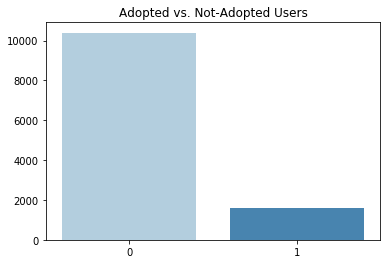

In [22]:
# Take a look at the distribution of the target class
sns.barplot(x = list(users['adopted'].value_counts().index), y = users['adopted'].value_counts(), palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users')

We can see that there is a heavy imbalance in the classess, so this will need to be handled when the data is split into training and test sets. 

In [23]:
df_ml = pd.get_dummies(users, columns = ['creation_source'], drop_first=True)

In [24]:
df_ml2 = df_ml.drop(['name', 'email', 'creation_time'], axis=1)

In [25]:
df_ml2.head()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_day,creation_month,creation_year,creation_hour,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1.398139e+09,1,0,11,0,1,4,2014,3,0,0,0,0
1,2,1.396238e+09,0,0,1,1,4,11,2013,3,1,0,0,0
2,3,1.363735e+09,0,0,94,0,1,3,2013,23,1,0,0,0
3,4,1.369210e+09,0,0,1,0,1,5,2013,8,0,0,0,0
4,5,1.358850e+09,0,0,193,0,3,1,2013,10,0,0,0,0


In [26]:
X = df_ml2.drop('adopted', axis=1)
y = df_ml2['adopted']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=21, stratify=y)

In [28]:

models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [29]:
names = []
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.922500
1  SVC  0.866667
2   LR  0.866667
3   DT  0.961250
4   RF  0.960417
5   GB  0.971250


In [30]:
names = []
scores = []
for name, model in models:
    
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  Name     Score
0  KNN  0.914583
1  SVC  0.866500
2   LR  0.866500
3   DT  0.941667
4   RF  0.959917
5   GB  0.968833


The best scoring model in both runs was the GradientBoostingClassifier, so that's the model we'll build out fully

In [31]:
gb = GradientBoostingClassifier(verbose=True)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print('Train Score:', round(gb.score(X_train,y_train),3))
print('Test Score:', round(gb.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           0.6609            0.80s
         2           0.5930            0.72s
         3           0.5458            0.68s
         4           0.5090            0.67s
         5           0.4793            0.78s
         6           0.4521            0.79s
         7           0.4261            0.79s
         8           0.4044            0.77s
         9           0.3872            0.76s
        10           0.3742            0.73s
        20           0.2969            0.60s
        30           0.2650            0.60s
        40           0.2326            0.51s
        50           0.2074            0.42s
        60           0.1873            0.39s
        70           0.1777            0.28s
        80           0.1627            0.18s
        90           0.1557            0.09s
       100           0.1473            0.00s
Train Score: 0.972
Test Score: 0.971


In [32]:
confusion_matrix(y_test, y_pred)

array([[2070,   10],
       [  59,  261]])

In [33]:
features = pd.Series(gb.feature_importances_, index=X.columns)

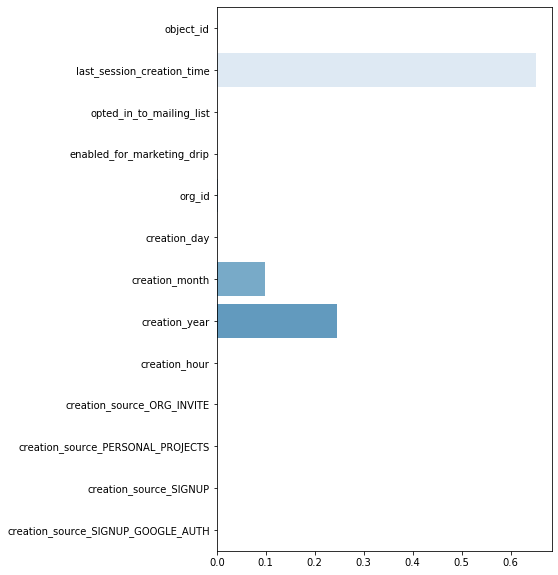

In [34]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=gb.feature_importances_, palette='Blues')
plt.show()

In [35]:
# Find feature importances
feature_importance = pd.DataFrame(gb.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,0.651218
creation_year,0.244985
creation_month,0.098646
org_id,0.002131
object_id,0.001999
creation_source_PERSONAL_PROJECTS,0.000329
creation_hour,0.000276
creation_day,0.000163
enabled_for_marketing_drip,0.000144
creation_source_SIGNUP,0.000069


With the default settings, we obtained a score of 97.2 on our test data

# Conclusions

The top predictor for whether a user was / wasn't adopted was their last session creation time. Unsurprisingly, the more recently a user logged in, the higher the chance they are engaged and are a regular user. This makes it less useful for giving an idea of how to get users engaged. It also seems that when the account was created (year and month) plays a big part in deciding how engaged a user is. 

The months / years the most adopted users created their account in can be cross referenced with any promotions / site activity during those times. That information could then be leveraged to determine why those users were originally pulled into creating an account. 